**Process:**

Get Image -> Smoothening -> Thresholding -> Laplacian -> Contour Detection -> Area finding -> Gall bladder detected

In [83]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

Text(0.5, 1.0, 'FILTERING')

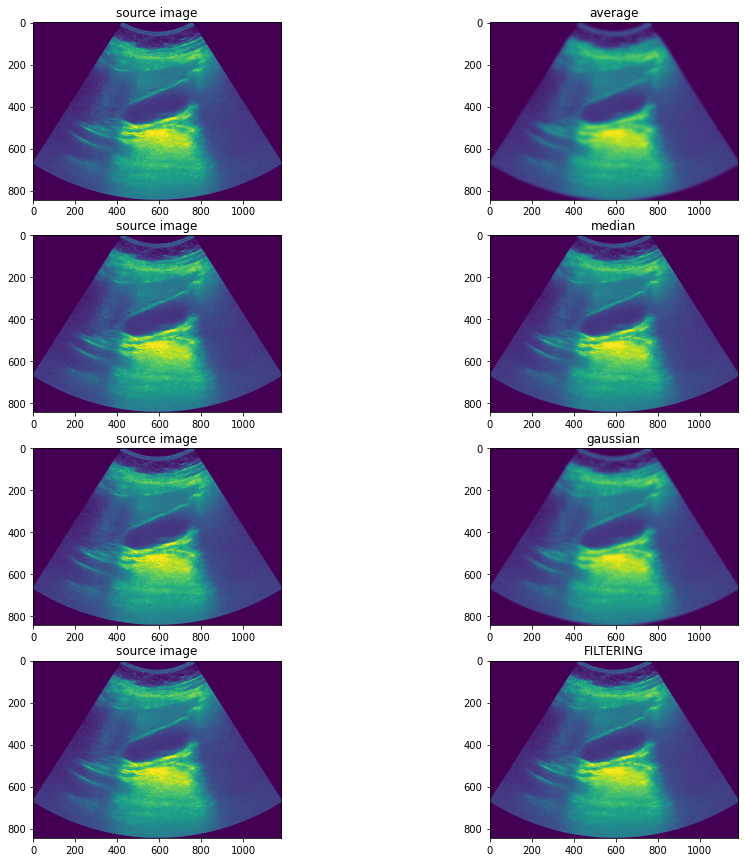

In [26]:
source_img = cv2.imread('0000.jpg', 0)

avg = source_img.copy()
med = source_img.copy()
gauss = source_img.copy()
bilateral = source_img.copy()

N = 100

for i in range(N):
  avg = cv2.blur(avg, (3, 3))

for i in range(N):
  med = cv2.medianBlur(med, 3)

for i in range(N):
  gauss = cv2.GaussianBlur(gauss, (3, 3), 0)

for i in range(N):
  bilateral = cv2.bilateralFilter(bilateral, 3, 5, 5)

fig, ax = plt.subplots(4, 2, figsize=(15, 15))

ax[0][0].imshow(source_img)
ax[0][0].set_title('source image')
ax[0][1].imshow(avg)
ax[0][1].set_title('average')

ax[1][0].imshow(source_img)
ax[1][0].set_title('source image')
ax[1][1].imshow(med)
ax[1][1].set_title('median')

ax[2][0].imshow(source_img)
ax[2][0].set_title('source image')
ax[2][1].imshow(gauss)
ax[2][1].set_title('gaussian')

ax[3][0].imshow(source_img)
ax[3][0].set_title('source image')
ax[3][1].imshow(bilateral)
ax[3][1].set_title('bilateral')

plt.title('FILTERING')

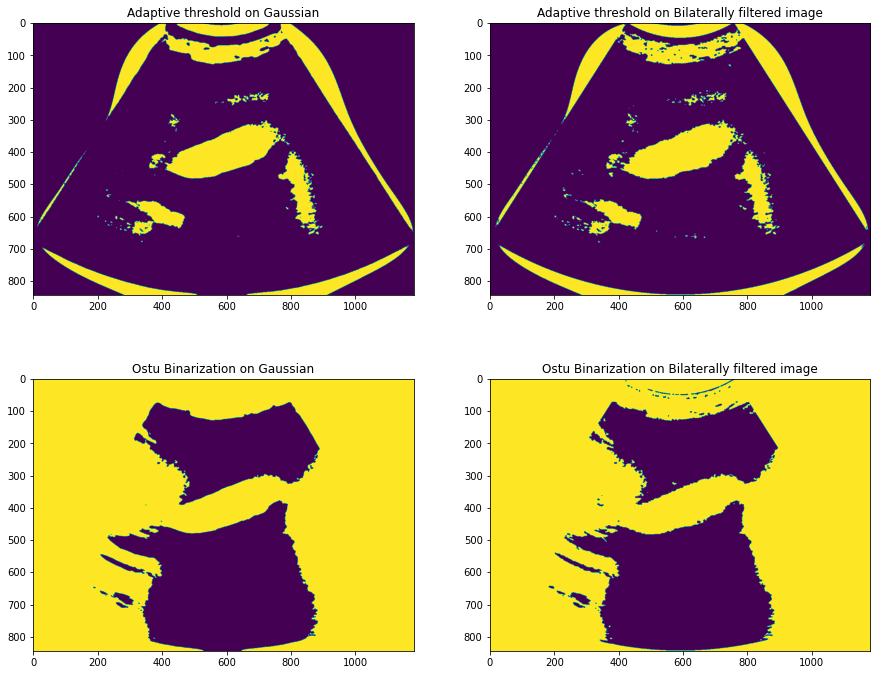

In [90]:
## We have following types of filtered images: Avg, Gauss, Med, Bilateral. Averaging is working the worst. So we consider the other three.
## Median still has some noise even after 100 runs. So, we consider only the other 2

## Now, we apply thresholding on this image. There are 3 types of thresholding possible: Simply thresholding, adaptive thresholding, and Otsu's binarization
## The simple thresholding won't work here since there are different lightening conditions in the image. So, we try the other 2

## Adaptive thresholding
adaptive_thresh_gauss = cv2.adaptiveThreshold(gauss, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 401, 17)
adaptive_thresh_bilateral = cv2.adaptiveThreshold(bilateral, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 401, 17)

fig, ax = plt.subplots(2, 2, figsize=(15, 12))

ax[0][0].imshow(adaptive_thresh_gauss)
ax[0][0].set_title('Adaptive threshold on Gaussian')

ax[0][1].imshow(adaptive_thresh_bilateral)
ax[0][1].set_title('Adaptive threshold on Bilaterally filtered image')


_ , ostu_gauss = cv2.threshold(gauss, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_ , ostu_bilateral = cv2.threshold(bilateral, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

ax[1][0].imshow(ostu_gauss)
ax[1][0].set_title('Ostu Binarization on Gaussian')

ax[1][1].imshow(ostu_bilateral)
ax[1][1].set_title('Ostu Binarization on Bilaterally filtered image')

plt.show()

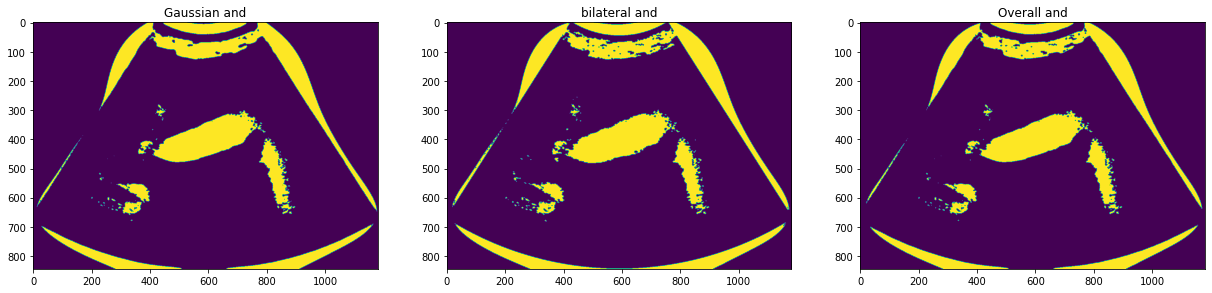

In [91]:
## Adaptive thresholding technique does better in identifying the regions of the gall bladder, whereas Ostu's binarization gives sharper regions

## We take their intersection to get the best region.

gaussian_and = cv2.bitwise_and(adaptive_thresh_gauss, ostu_gauss)
bilateral_and = cv2.bitwise_and(adaptive_thresh_bilateral, ostu_bilateral)

overall_and = cv2.bitwise_and(gaussian_and, bilateral_and)

fig, ax = plt.subplots(1, 3, figsize = (21, 7.5))
ax[0].imshow(gaussian_and)
ax[0].set_title('Gaussian and')

ax[1].imshow(bilateral_and)
ax[1].set_title('bilateral and')

ax[2].imshow(overall_and)
ax[2].set_title('Overall and')

plt.show()

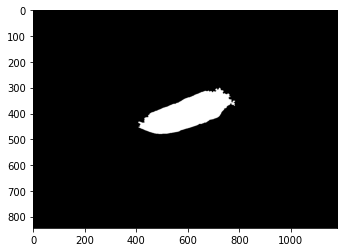

In [92]:
## Visually, the overall_and seems the best

laplace = cv2.Laplacian(overall_and, -1, 3)

#Find all the contours generated by the laplacian
contours, hierarchy = cv2.findContours(laplace.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#Go through all the contours, calculate their area and find the contour with maximum area in a range.
#The range is determined by the size of the input image.
m = -1
max_area = -1
for i, cont in enumerate(contours):
    area = cv2.contourArea(cont)
    if((area > max_area) and (area < 0.1*source_img.size)):
        max_area = area
        m = i

#draw the contour found[Gall bladder] on a blank canvas. Fill the entire contour
mask = np.zeros(source_img.shape+(3, ), dtype='uint8')
cv2.drawContours(mask, [contours[m]], -1, (255,255,255), -1)

plt.imshow(mask)

In [104]:
def get_gall_bladder(source_of_image):
  source_img = cv2.imread(source_of_image, 0)

  gauss = source_img.copy()
  bilateral = source_img.copy()

  N = 100
  for i in range(N):
    gauss = cv2.GaussianBlur(gauss, (3, 3), 0)

  for i in range(N):
    bilateral = cv2.bilateralFilter(bilateral, 3, 5, 5)

  ## Adaptive thresholding
  adaptive_thresh_gauss = cv2.adaptiveThreshold(gauss, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 401, 17)
  adaptive_thresh_bilateral = cv2.adaptiveThreshold(bilateral, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 401, 17)

  _ , ostu_gauss = cv2.threshold(gauss, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  _ , ostu_bilateral = cv2.threshold(bilateral, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  ## Adaptive thresholding technique does better in identifying the regions of the gall bladder, whereas Ostu's binarization gives sharper regions
  ## We take their intersection to get the best region.

  gaussian_and = cv2.bitwise_and(adaptive_thresh_gauss, ostu_gauss)
  bilateral_and = cv2.bitwise_and(adaptive_thresh_bilateral, ostu_bilateral)

  overall_and = cv2.bitwise_and(gaussian_and, bilateral_and)

  ## Visually, the overall_and seems the best

  laplace = cv2.Laplacian(overall_and, -1, 3)

  ## Find all the contours generated by the laplacian
  contours, hierarchy = cv2.findContours(laplace.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  ## Go through all the contours, calculate their area and find the contour with maximum area in a range.
  ## The range is determined by the size of the input image.
  m = -1
  max_area = -1
  for i, cont in enumerate(contours):
      area = cv2.contourArea(cont)
      if((area > max_area) and (area < 0.1*source_img.size)):
          max_area = area
          m = i

  ## draw the contour found[Gall bladder] on a blank canvas. Fill the entire contour
  mask = np.zeros(source_img.shape+(3, ), dtype='uint8')
  cv2.drawContours(mask, [contours[m]], -1, (255,255,255), -1)

  return mask

In [108]:
images = [('000' + str(i) + '.jpg') for i in range(10)]

#fig, ax = plt.subplots(len(images), 1, figsize = (5, 50))
i = 0
for image in images:
  mask = get_gall_bladder(image)
  cv2.imwrite('mask_' + image, mask)

References: https://github.com/rajat499/gallbladder-extraction